In [16]:
import numpy as np
import matplotlib.pyplot as plt
import random
import math
import cv2
import nibabel as nib
from scipy import ndimage
import tensorflow as tf
import scipy
from scipy.stats import wilcoxon

In [24]:
#save the image slices, masks, and information about one-click

posPatients = np.array([2,4,9,11,12,15,16,17,18,19,21,22,5,6,7,8,13,14])
locList = []
maskList = []
posList = []

img_height=64
limit=0.25
pixLimit=5

comList = []
pixList = []

for i in range(18):
    if posPatients[i]==12:
        img_path = 'C:/Users/Oona/Documents/Tpc/hnc/anom_data/positiiviset/12_anon/12_maski/12_maskit.img'
    else:
        img_path = 'C:/Users/Oona/Documents/Tpc/hnc/anom_data/positiiviset/{}_anon/{}_maski/{}_maski.img'.format(
                        posPatients[i],posPatients[i],posPatients[i])
    img = nib.load(img_path)
    img_data = img.get_fdata()
    locations = []
    masks = []
    for j in range(img_data.shape[2]):
        slice = np.array(img_data[:,:,j])
        if np.max(slice)>0:
            slice=cv2.resize(slice,(img_height,img_height))
            for k in range(img_height):
                for l in range(img_height):
                    if slice[k,l]>limit:
                        slice[k,l]=1
                    else:
                        slice[k,l]=0
            if np.sum(slice)>pixLimit:
                locations.append(j)
                masks.append(slice)
    locList.append(np.array(locations))
    maskList.append(masks)

maskList = maskList[0:12]+[maskList[12]+maskList[13]]+[maskList[14]+maskList[15]]+[maskList[16]+maskList[17]]

for i in range(18):
    img_path = 'C:/Users/Oona/Documents/Tpc/hnc/anom_data/positiiviset/{}_anon/{}_nifti_pet/{}_nifti_pet.img'.format(
                        posPatients[i],posPatients[i],posPatients[i])
    img = nib.load(img_path)
    img_data = img.get_fdata()
    pos = []
    for j in range(len(locList[i])):
        pos.append(cv2.resize(np.array(img_data[:,:,locList[i][j]]),(img_height,img_height)))
    posList.append(pos)

posList = posList[0:12]+[posList[12]+posList[13]]+[posList[14]+posList[15]]+[posList[16]+posList[17]]

for i in range(15):
    comImgs=[]
    for j in range(len(maskList[i])):
        img=maskList[i][j]
        com=ndimage.measurements.center_of_mass(img)
        img1=np.zeros((img_height,img_height))
        img1[round(com[0]),round(com[1])]=1
        comImgs.append(img1)
    comList.append(comImgs)

for i in range(15):
    pixImgs=[]
    for j in range(len(maskList[i])):
        img=maskList[i][j]
        options=[]
        for k in range(img_height):
            for l in range(img_height):
                if img[k,l]==1:
                    options.append(np.array([k,l]))
        img1=np.zeros((img_height,img_height))
        onePix=random.choice(options)
        img1[onePix[0],onePix[1]]=1
        pixImgs.append(img1)
    pixList.append(pixImgs)

In [47]:
#create train and test data sets for image data and one-click information (x) and correct masks (y)

def splitIntoSets(posList,maskList,comList,pixList,testSetPatients,type):

    #type is 'com' for center of mass, 'pix' for random positive pixel, and 'no' if neither

    x_train = []
    y_train = []
    x_test = []
    y_test = []

    for i in range(15):
        if i in testSetPatients:
            for j in range(len(posList[i])):
                img=(posList[i][j]-np.min(posList[i][j]))/(np.max(posList[i][j])-np.min(posList[i][j]))
                if type=='com':
                    x_test.append(np.rollaxis(np.array([img,comList[i][j]]),0,3))
                if type=='pix':
                    x_test.append(np.rollaxis(np.array([img,pixList[i][j]]),0,3))
                if type=='no':
                    x_test.append(img)
                y_test.append(cv2.resize(maskList[i][j],(img_height,img_height)))   
        else:
            for j in range(len(posList[i])):
                img=(posList[i][j]-np.min(posList[i][j]))/(np.max(posList[i][j])-np.min(posList[i][j]))
                if type=='com':
                    x_train.append(np.rollaxis(np.array([img,comList[i][j]]),0,3))
                if type=='pix':
                    x_train.append(np.rollaxis(np.array([img,pixList[i][j]]),0,3))
                if type=='no':
                    x_train.append(img)
                y_train.append(cv2.resize(maskList[i][j],(img_height,img_height)))  

    x_train=np.array(x_train)
    y_train=np.array(y_train)
    x_test=np.array(x_test)
    y_test=np.array(y_test)

    return([x_train,y_train,x_test,y_test])

#Unet CNN for segmentation

def unetForSegmentation(shape):

    img_height=shape[1]
    if len(shape)==4:
        chl_number=shape[3]
    else:
        chl_number=1

    #U-Net model
    inputs = tf.keras.layers.Input(shape=(img_height,img_height,chl_number))

    #Contraction path
    c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(inputs)
    c1 = tf.keras.layers.Dropout(0.1)(c1)
    c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)

    c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = tf.keras.layers.Dropout(0.1)(c2)
    c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)

    c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = tf.keras.layers.Dropout(0.2)(c3)
    c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)

    #Expansive path
    u8 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c3)
    u8 = tf.keras.layers.concatenate([u8, c2])
    c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = tf.keras.layers.Dropout(0.1)(c8)
    c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)

    u9 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = tf.keras.layers.concatenate([u9, c1], axis=3)
    c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = tf.keras.layers.Dropout(0.1)(c9)
    c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)

    outputs = tf.keras.layers.Conv2D(1, (1,1), activation='linear')(c9) #sigmoid or linear

    model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
    model.compile(optimizer='adam', loss='binary_crossentropy')

    return model

#count the dice scores between predictions converted into binary with limit and y_test (real mask of the test set)

def dicesForLimit(predictions,y_test,limit):

    dices=np.zeros((len(y_test)))

    img_height=predictions[0].shape[0]

    for k in range(len(y_test)):
        TP=0
        FN=0
        FP=0
        for i in range(img_height):
            for j in range(img_height):
                if y_test[k,i,j]>0.5 and predictions[k,i,j]>limit:
                    TP+=1
                if y_test[k,i,j]>0.5 and predictions[k,i,j]<limit:
                    FN+=1
                if y_test[k,i,j]<0.5 and predictions[k,i,j]>limit:
                    FP+=1
        if TP+FN+FP>0:
            dices[k]=2*TP/(2*TP+FN+FP)

    return(dices)

#find the best limit to convert predictions into binary

def optimizeDiceLimit(predictions,y_test):

    potLimits=0.01*np.array(range(0,100))
    medianDices = []

    for i in range(len(potLimits)):
        medianDices.append(np.median(dicesForLimit(predictions,y_test,potLimits[i])))

    limit=potLimits[medianDices.index(max(medianDices))]

    return(limit)

#create one binary mask

def turnIntoBinaryMask(img,lim):

    img_height=img.shape[0]

    binM=np.zeros((img_height,img_height))

    for i in range(img_height):
        for j in range(img_height):
            if img[i][j]>lim:
                binM[i][j]=1
    
    return binM

#algorithm for removing segmentation further away from the one-click pixel

def removePixels(predictions,x_test,limit):

    predictions1=[]

    for k in range(len(predictions)):

        img=turnIntoBinaryMask(predictions[k],limit)
        ind=np.unravel_index(np.argmax(x_test[k,:,:,1],axis=None),img.shape)
        c=True

        k0=ind[0]-1
        k1=ind[0]+1
        k2=ind[1]-1
        k3=ind[1]+1

        while c:
            c=False
            if np.sum(img[k0,k2:k3])>0:
                if k0>0:
                    c=True
                k0=np.max([k0-1,0])
            if np.sum(img[k1,k2:k3])>0:
                if k1<64:
                    c=True
                k1=np.min([k1+1,63])
            if np.sum(img[k0:k1,k2])>0:
                if k2>0:
                    c=True
                k2=np.max([k2-1,0])
            if np.sum(img[k0:k1,k3])>0:
                if k3<63:
                    c=True
            k3=np.min([k3+1,63])

        for i in range(img_height):
            for j in range(img_height):
                if i<k0 or i>k1 or j<k2 or j>k3: 
                    img[i,j]=0

        predictions1.append(img)

    predictions1=np.array(predictions1)

    return(predictions1)

In [134]:
#create data sets from certain test set pairs

tsn=1

if tsn==1:
    testSetPatients=[3,10,12]
if tsn==2:
    testSetPatients=[7,8,9]
if tsn==3:
    testSetPatients=[2,4,11]
if tsn==4:
    testSetPatients=[1,5,14]
if tsn==5:
    testSetPatients=[0,6,13]

x_train,y_train,x_test,y_test=splitIntoSets(posList,maskList,comList,pixList,testSetPatients,'com')

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(112, 64, 64, 2)
(112, 64, 64)
(29, 64, 64, 2)
(29, 64, 64)


Epoch 1/100
3/3 [==============================] - 4s 939ms/step - loss: 0.1103 - val_loss: 0.1091
Epoch 2/100
3/3 [==============================] - 2s 700ms/step - loss: 0.1079 - val_loss: 0.0958
Epoch 3/100
3/3 [==============================] - 2s 726ms/step - loss: 0.0924 - val_loss: 0.0583
Epoch 4/100
3/3 [==============================] - 2s 813ms/step - loss: 0.0712 - val_loss: 0.0315
Epoch 5/100
3/3 [==============================] - 2s 684ms/step - loss: 0.0578 - val_loss: 0.0301
Epoch 6/100
3/3 [==============================] - 2s 710ms/step - loss: 0.0507 - val_loss: 0.0503
Epoch 7/100
3/3 [==============================] - 2s 693ms/step - loss: 0.0430 - val_loss: 0.0245
Epoch 8/100
3/3 [==============================] - 2s 705ms/step - loss: 0.0396 - val_loss: 0.0558
Epoch 9/100
3/3 [==============================] - 2s 698ms/step - loss: 0.0452 - val_loss: 0.0520
Epoch 10/100
3/3 [==============================] - 2s 695ms/step - loss: 0.0373 - val_loss: 0.0234
Epoch 11/

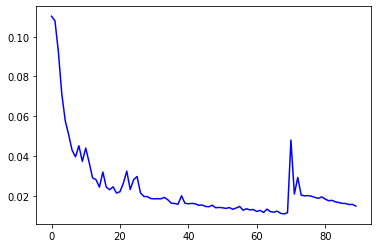

In [135]:
#run the model

model=unetForSegmentation(x_test.shape)
numEpochs=100
earlystopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',mode='min', patience=30, restore_best_weights=True)
history=model.fit(x=x_train,y=y_train,epochs=numEpochs,validation_split=0.3,callbacks=[earlystopping],shuffle=True)
trainPredictions=model.predict(x_train)
predictions=model.predict(x_test)
plt.plot(range(len(history.history['loss'])),history.history['loss'],color='blue')

In [136]:
#print the results by using predictions of the training data to find limit for converting test set predictions into binary

lim=optimizeDiceLimit(trainPredictions,y_train)
print(lim)
dices=dicesForLimit(predictions,y_test,lim)
print(np.round(np.median(dices),3))
print(np.round(np.percentile(dices,75)-np.percentile(dices,25),3))
print(np.round(np.mean(dices),3))
print(np.round(np.std(dices),3))

0.38
0.533
0.408
0.553
0.277


In [137]:
dices

array([0.        , 0.4137931 , 0.83333333, 0.91891892, 0.92307692,
       0.90566038, 0.94285714, 0.87234043, 0.77192982, 0.70491803,
       0.74418605, 0.7394958 , 0.80898876, 0.8       , 0.47058824,
       0.53333333, 0.58536585, 0.32142857, 0.28571429, 0.41509434,
       0.46808511, 0.49019608, 0.39215686, 0.31578947, 0.33613445,
       0.515625  , 0.53703704, 0.        , 0.        ])

In [113]:
np.savetxt('ts{}_com_dices.txt'.format(tsn),dices)

for i in range(len(trainPredictions)):
    np.savetxt('ts{}_{}_com_trainPredictions.txt'.format(tsn,i), trainPredictions[i][:,:,0])

for i in range(len(predictions)):
    np.savetxt('ts{}_{}_com_predictions.txt'.format(tsn,i), predictions[i][:,:,0])

In [78]:
np.savetxt('ts{}_pix_dices.txt'.format(tsn),dices)

for i in range(len(trainPredictions)):
    np.savetxt('ts{}_{}_pix_trainPredictions.txt'.format(tsn,i), trainPredictions[i][:,:,0])

for i in range(len(predictions)):
    np.savetxt('ts{}_{}_pix_predictions.txt'.format(tsn,i), predictions[i][:,:,0])

In [51]:
np.savetxt('ts{}_no_dices.txt'.format(tsn),dices)

for i in range(len(trainPredictions)):
    np.savetxt('ts{}_{}_no_trainPredictions.txt'.format(tsn,i), trainPredictions[i][:,:,0])

for i in range(len(predictions)):
    np.savetxt('ts{}_{}_no_predictions.txt'.format(tsn,i), predictions[i][:,:,0])

In [52]:
x_train,y_train,x_test,y_test=splitIntoSets(posList,maskList,comList,pixList,testSetPatients,'pix')
predictions1=removePixels(predictions,x_test,lim)
dices1=dicesForLimit(predictions1,y_test,lim)
print(np.round(np.median(dices1),3))
print(np.round(np.percentile(dices1,75)-np.percentile(dices1,25),3))
print(np.round(np.mean(dices1),3))
print(np.round(np.std(dices1),3))
np.savetxt('ts{}_dices1_pix.txt'.format(tsn),dices1)

0.621
0.34
0.55
0.232


In [53]:
x_train,y_train,x_test,y_test=splitIntoSets(posList,maskList,comList,pixList,testSetPatients,'com')
predictions1=removePixels(predictions,x_test,lim)
dices1=dicesForLimit(predictions1,y_test,lim)
print(np.round(np.median(dices1),3))
print(np.round(np.percentile(dices1,75)-np.percentile(dices1,25),3))
print(np.round(np.mean(dices1),3))
print(np.round(np.std(dices1),3))
np.savetxt('ts{}_dices1_com.txt'.format(tsn),dices1)

0.667
0.327
0.581
0.198


In [2]:
d1=np.loadtxt('C:/Users/Oona/Documents/Tpc/hnc/click/tss/ts1_no_dices.txt')
d2=np.loadtxt('C:/Users/Oona/Documents/Tpc/hnc/click/tss/ts2_no_dices.txt')
d3=np.loadtxt('C:/Users/Oona/Documents/Tpc/hnc/click/tss/ts3_no_dices.txt')
d4=np.loadtxt('C:/Users/Oona/Documents/Tpc/hnc/click/tss/ts4_no_dices.txt')
d5=np.loadtxt('C:/Users/Oona/Documents/Tpc/hnc/click/tss/ts5_no_dices.txt')
noDices=np.concatenate((d1,d2,d3,d4,d5))

In [3]:
d1=np.loadtxt('C:/Users/Oona/Documents/Tpc/hnc/click/tss/ts1_dices1_pix.txt')
d2=np.loadtxt('C:/Users/Oona/Documents/Tpc/hnc/click/tss/ts2_dices1_pix.txt')
d3=np.loadtxt('C:/Users/Oona/Documents/Tpc/hnc/click/tss/ts3_dices1_pix.txt')
d4=np.loadtxt('C:/Users/Oona/Documents/Tpc/hnc/click/tss/ts4_dices1_pix.txt')
d5=np.loadtxt('C:/Users/Oona/Documents/Tpc/hnc/click/tss/ts5_dices1_pix.txt')
dices1Pix=np.concatenate((d1,d2,d3,d4,d5))

In [4]:
d1=np.loadtxt('C:/Users/Oona/Documents/Tpc/hnc/click/tss/ts1_dices1_com.txt')
d2=np.loadtxt('C:/Users/Oona/Documents/Tpc/hnc/click/tss/ts2_dices1_com.txt')
d3=np.loadtxt('C:/Users/Oona/Documents/Tpc/hnc/click/tss/ts3_dices1_com.txt')
d4=np.loadtxt('C:/Users/Oona/Documents/Tpc/hnc/click/tss/ts4_dices1_com.txt')
d5=np.loadtxt('C:/Users/Oona/Documents/Tpc/hnc/click/tss/ts5_dices1_com.txt')
dices1Com=np.concatenate((d1,d2,d3,d4,d5))

In [5]:
d1=np.loadtxt('C:/Users/Oona/Documents/Tpc/hnc/click/tss/ts1_pix_dices.txt')
d2=np.loadtxt('C:/Users/Oona/Documents/Tpc/hnc/click/tss/ts2_pix_dices.txt')
d3=np.loadtxt('C:/Users/Oona/Documents/Tpc/hnc/click/tss/ts3_pix_dices.txt')
d4=np.loadtxt('C:/Users/Oona/Documents/Tpc/hnc/click/tss/ts4_pix_dices.txt')
d5=np.loadtxt('C:/Users/Oona/Documents/Tpc/hnc/click/tss/ts5_pix_dices.txt')
pixDices=np.concatenate((d1,d2,d3,d4,d5))

In [6]:
d1=np.loadtxt('C:/Users/Oona/Documents/Tpc/hnc/click/tss/ts1_com_dices.txt')
d2=np.loadtxt('C:/Users/Oona/Documents/Tpc/hnc/click/tss/ts2_com_dices.txt')
d3=np.loadtxt('C:/Users/Oona/Documents/Tpc/hnc/click/tss/ts3_com_dices.txt')
d4=np.loadtxt('C:/Users/Oona/Documents/Tpc/hnc/click/tss/ts4_com_dices.txt')
d5=np.loadtxt('C:/Users/Oona/Documents/Tpc/hnc/click/tss/ts5_com_dices.txt')
comDices=np.concatenate((d1,d2,d3,d4,d5))

In [11]:
dices=comDices
print(np.round(np.median(dices),3))
print(np.round(np.percentile(dices,75)-np.percentile(dices,25),3))
print(np.round(np.mean(dices),3))
print(np.round(np.std(dices),3))

0.691
0.317
0.633
0.231


In [12]:
print(wilcoxon(x=noDices,y=dices1Pix))
print(wilcoxon(x=noDices,y=dices1Com))
print(wilcoxon(x=noDices,y=pixDices))
print(wilcoxon(x=noDices,y=comDices))

WilcoxonResult(statistic=802.0, pvalue=0.0016092406282957703)
WilcoxonResult(statistic=714.0, pvalue=0.0007598625459485163)
WilcoxonResult(statistic=4813.0, pvalue=0.9129415319791908)
WilcoxonResult(statistic=3666.0, pvalue=0.01170634810135393)


In [13]:
print(wilcoxon(x=dices1Pix,y=dices1Com))
print(wilcoxon(x=dices1Pix,y=pixDices))
print(wilcoxon(x=dices1Pix,y=comDices))

WilcoxonResult(statistic=67.0, pvalue=0.9587607499379828)
WilcoxonResult(statistic=3198.0, pvalue=0.00030257034716715673)
WilcoxonResult(statistic=4363.0, pvalue=0.29122161622983933)


In [14]:
print(wilcoxon(x=dices1Com,y=pixDices))
print(wilcoxon(x=dices1Com,y=comDices))

WilcoxonResult(statistic=3075.0, pvalue=0.00010931018838019725)
WilcoxonResult(statistic=4412.0, pvalue=0.4992250319312319)


In [15]:
print(wilcoxon(x=pixDices,y=comDices))

WilcoxonResult(statistic=3530.0, pvalue=0.005003439061753743)


In [17]:
def f_test(x,y):

    x=np.array(x)
    y=np.array(y)
    f=np.var(x,ddof=1)/np.var(y,ddof=1)
    dfn=x.size-1
    dfd=y.size-1
    p=2*min(1-scipy.stats.f.cdf(f,dfn,dfd),scipy.stats.f.cdf(f,dfn,dfd))
    return(p)

In [18]:
print(f_test(x=noDices,y=dices1Pix))
print(f_test(x=noDices,y=dices1Com))
print(f_test(x=noDices,y=pixDices))
print(f_test(x=noDices,y=comDices))

0.607777136746369
0.47313237276510284
0.015211511715367942
0.7088431909698607


In [19]:
print(f_test(x=dices1Pix,y=dices1Com))
print(f_test(x=dices1Pix,y=pixDices))
print(f_test(x=dices1Pix,y=comDices))

0.8381368448675997
0.0033453208407907553
0.3754259464705809


In [20]:
print(f_test(x=dices1Com,y=pixDices))
print(f_test(x=dices1Com,y=comDices))

0.0017182641502166973
0.275589723895439


In [21]:
print(f_test(x=pixDices,y=comDices))

0.0396666290484341


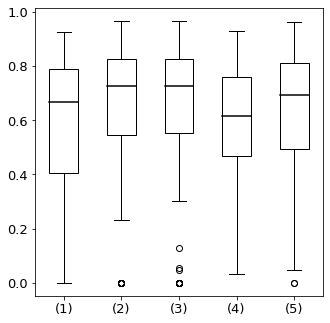

In [22]:
d=[noDices,dices1Pix,dices1Com,pixDices,comDices]
fig=plt.figure(figsize=(4,4))
axi=fig.add_axes([0,0,1,1])
bplot=axi.boxplot(d,patch_artist=True,positions=[1,2,3,4,5])
colors=5*['white']
for patch,color in zip(bplot['boxes'],colors):
    patch.set_facecolor(color)
for median in bplot['medians']:
    median.set(color='black',linewidth=1.5)
plt.xticks([1,2,3,4,5],['(1)','(2)','(3)','(4)','(5)'],fontsize=13)
plt.yticks(fontsize=13)
fig=plt.gcf()
plt.show()
fig.savefig('fig_plt_5',bbox_inches='tight')

In [53]:
trainPredictions[0,0,0]

-0.06609583646059036

In [ ]:
tsn=1
testSetPatients=[3,10,12]
x_train,y_train,x_test,y_test=splitIntoSets(posList,maskList,comList,pixList,testSetPatients,'no')

trainPredictions=[]
for i in range(len(x_train)):
    trainPredictions.append(np.loadtxt('tss/ts{}_{}_no_trainPredictions.txt'.format(tsn,i)))
trainPredictions=np.array(trainPredictions)
lim=optimizeDiceLimit(trainPredictions,y_train) #0.30
print(lim)

trainPredictions=[]
for i in range(len(x_train)):
    trainPredictions.append(np.loadtxt('tss/ts{}_{}_pix_trainPredictions.txt'.format(tsn,i)))
trainPredictions=np.array(trainPredictions)
lim0=optimizeDiceLimit(trainPredictions,y_train) #0.33
print(lim0)

trainPredictions=[]
for i in range(len(x_train)):
    trainPredictions.append(np.loadtxt('tss/ts{}_{}_com_trainPredictions.txt'.format(tsn,i)))
trainPredictions=np.array(trainPredictions)
lim1=optimizeDiceLimit(trainPredictions,y_train) #0.42
print(lim1)

predictions=[]
for i in range(len(x_test)):
    predictions.append(np.loadtxt('tss/ts{}_{}_no_predictions.txt'.format(tsn,i)))
predictions=np.array(predictions)

i=3

img=x_test[i]**0.3
img=cv2.rotate(img,cv2.cv2.ROTATE_90_COUNTERCLOCKWISE)
plt.imshow(img,cmap='gray')
fig=plt.gcf()
plt.axis('off')
fig.savefig('fig_b_img',bbox_inches='tight')
plt.show()

img=y_test[i]
img=cv2.rotate(img,cv2.cv2.ROTATE_90_COUNTERCLOCKWISE)
plt.imshow(img,cmap='gray')
fig=plt.gcf()
plt.axis('off')
#fig.savefig('fig_b_r',bbox_inches='tight')
plt.show()

img=predictions[i]
img=cv2.rotate(img,cv2.cv2.ROTATE_90_COUNTERCLOCKWISE)
img=turnIntoBinaryMask(img,lim)
plt.imshow(img,cmap='gray')
fig=plt.gcf()
plt.axis('off')
#fig.savefig('fig_b_1',bbox_inches='tight')
plt.show()
print(noDices[i])

x_train,y_train,x_test,y_test=splitIntoSets(posList,maskList,comList,pixList,testSetPatients,'pix')
predictions1=removePixels(predictions,x_test,lim)
img=predictions1[i]
img=cv2.rotate(img,cv2.cv2.ROTATE_90_COUNTERCLOCKWISE)
plt.imshow(img,cmap='gray')
fig=plt.gcf()
plt.axis('off')
#fig.savefig('fig_b_',bbox_inches='tight')
plt.show()
print(dices1Pix[i])

x_train,y_train,x_test,y_test=splitIntoSets(posList,maskList,comList,pixList,testSetPatients,'com')
predictions1=removePixels(predictions,x_test,lim)
img=predictions1[i]
img=cv2.rotate(img,cv2.cv2.ROTATE_90_COUNTERCLOCKWISE)
plt.imshow(img,cmap='gray')
fig=plt.gcf()
plt.axis('off')
#fig.savefig('fig_b_3',bbox_inches='tight')
plt.show()
print(dices1Com[i])

img=np.loadtxt('tss/ts{}_{}_pix_predictions.txt'.format(tsn,i))
img=cv2.rotate(img,cv2.cv2.ROTATE_90_COUNTERCLOCKWISE)
img=turnIntoBinaryMask(img,lim0)
plt.imshow(img,cmap='gray')
fig=plt.gcf()
plt.axis('off')
#fig.savefig('fig_b_4',bbox_inches='tight')
plt.show()
print(pixDices[i])

img=np.loadtxt('tss/ts{}_{}_com_predictions.txt'.format(tsn,i))
img=cv2.rotate(img,cv2.cv2.ROTATE_90_COUNTERCLOCKWISE)
img=turnIntoBinaryMask(img,lim1)
plt.imshow(img,cmap='gray')
fig=plt.gcf()
plt.axis('off')
#fig.savefig('fig_b_5',bbox_inches='tight')
plt.show()
print(comDices[i])